# 量子ボリュームの測定

## 前書き

**量子ボリューム (QV)** は、適度なサイズで近い将来に実現されるの量子コンピューター(near-term quantum computers)で具体的なプロトコルを使って測定できる単一の数値のメトリックです。QVメソッドでは、その量子コンピューターが正常に実装できる最大のランダムな量子回路の幅(width)と深さ(depth)を定量化します。量子コンピューティングシステムが、より高い量子ボリュームを持つためには、操作の忠実度が高いこと、量子ビットの連結数が多いこと、ゲートセットのキャリブレーションがより正確にされていること、回路書き換えのツールチェインを持つことが必要となってきます。


## 量子ボリュームのプロトコル

QVプロトコル([1]を参照)は、次のステップで構成されます：

(最初にデモに関連するqiskitのクラスをインポートする必要があります。)

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Import Qiskit classes
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#QVの機能をインポート
import qiskit.ignis.verification.quantum_volume as qv

### ステップ 1: QVシークエンスを生成する

量子アルゴリズムが、2量子ビットのユニタリーゲートで作られた多項式サイズの量子回路として表現できることはよく知られています。したがって、モデルとなる回路は、量子ビットの番号がランダムな並びとなる$d$個の層(layer)で構成され、その後にランダムな($SU(4)$による)2量子ビットゲートが続きます。回路の幅$m$が奇数の場合、各層で1つの量子ビットがアイドルになります。

より正確には、**深さ$d$** 、 **幅$m$** の **QV回路** は、$d$個の層のシーケンス$U = U^{(d)}...U^{(2)}U^{(1)}$ です：


$$ U^{(t)} = U^{(t)}_{\pi_t(m'-1),\pi_t(m)} \otimes ... \otimes U^{(t)}_{\pi_t(1),\pi_t(2)} $$


それぞれ時間が$t = 1 ... d$でラベルづけされ、$m' = 2 \lfloor n/2 \rfloor$の量子ビットに作用します。各層は、一様にランダムな順列$\pi_t \in S_m$($m$は$m$量子ビットを表す)を選択し、$SU(4)$のHaar測定から、量子ビット$a$および$b$に作用する各$U^{(t)}_{a,b}$をサンプリングすることによって指定されます。

次の例では、Q0、Q1、Q3、Q5、Q7、Q10の6つの量子ビットがあります。 フルセットまでのサブセットを調べます（各ボリューム回路の深さは、サブセットの量子ビットの数と同じです）。

In [2]:
# qubit_lists: QV回路を生成するための量子ビットサブセットのリストのリスト
qubit_lists = [[0,1,3],[0,1,3,5],[0,1,3,5,7],[0,1,3,5,7,10]]
# ntrials: サブセットごとに作成するランダム回路の数
ntrials = 100

量子ボリュームシーケンスを生成します。 （実行に時間がかかりすぎないように）小さな例から始めます。

In [3]:
import warnings
warnings.filterwarnings('ignore')
qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

例として、最初のQVシーケンスに対応する回路を表示します。 理想的な回路は最初のn量子ビットで実行されることに注意してください（nはサブセット内の量子ビットの数です）。

In [4]:
#nomeasの最初の試行をtranspiler に通して回路を表示します
qv_circs_nomeas[0] = qiskit.compiler.transpile(qv_circs_nomeas[0], basis_gates=['u1','u2','u3','cx'])

In [5]:
qv_circs_nomeas[0][0].draw(fold=-1)

         ┌───────────────────────┐        ┌─────────────────────────┐     »
qr_0: ───┤ U3(1.626,-2.616,3.53) ├─────■──┤ U3(0.74089,-pi/2,-pi/2) ├──■──»
      ┌──┴───────────────────────┴──┐  │  └─────────────────────────┘  │  »
qr_1: ┤ U3(1.2194,-0.082533,4.5009) ├──┼───────────────────────────────┼──»
      └─┬──────────────────────────┬┘┌─┴─┐    ┌─────────────────┐    ┌─┴─┐»
qr_2: ──┤ U3(1.9217,-2.201,2.0955) ├─┤ X ├────┤ U2(-pi,-3.1208) ├────┤ X ├»
        └──────────────────────────┘ └───┘    └─────────────────┘    └───┘»
cr_0: ════════════════════════════════════════════════════════════════════»
                                                                          »
cr_1: ════════════════════════════════════════════════════════════════════»
                                                                          »
cr_2: ════════════════════════════════════════════════════════════════════»
                                                                          »
«      ┌────

### Step 2: ステップ 2: 理想的なQV回路をシミュレーションする

量子ボリュームメソッドでは、各回路の理想的な出力がわかっている必要があるため、Aerの状態ベクトルシミュレーターを使用して理想的な結果を取得します。

In [6]:
#ユニタリー行列はグローバルフェーズではidentity(単位行列)です
sv_sim = qiskit.Aer.get_backend('aer_simulator')
ideal_results = []
for trial in range(ntrials):
    clear_output(wait=True)
    for qc in qv_circs_nomeas[trial]:
        qc.save_statevector()
    result = qiskit.execute(qv_circs_nomeas[trial], backend=sv_sim).result()
    ideal_results.append(result)
    print(f'Simulated trial {trial+1}/{ntrials}')

Simulating trial 0
Simulating trial 1
Simulating trial 2
Simulating trial 3
Simulating trial 4
Simulating trial 5
Simulating trial 6
Simulating trial 7
Simulating trial 8
Simulating trial 9
Simulating trial 10
Simulating trial 11
Simulating trial 12
Simulating trial 13
Simulating trial 14
Simulating trial 15
Simulating trial 16
Simulating trial 17
Simulating trial 18
Simulating trial 19
Simulating trial 20
Simulating trial 21
Simulating trial 22
Simulating trial 23
Simulating trial 24
Simulating trial 25
Simulating trial 26
Simulating trial 27
Simulating trial 28
Simulating trial 29
Simulating trial 30
Simulating trial 31
Simulating trial 32
Simulating trial 33
Simulating trial 34
Simulating trial 35
Simulating trial 36
Simulating trial 37
Simulating trial 38
Simulating trial 39
Simulating trial 40
Simulating trial 41
Simulating trial 42
Simulating trial 43
Simulating trial 44
Simulating trial 45
Simulating trial 46
Simulating trial 47
Simulating trial 48
Simulating trial 49


次に、この理想的な結果を量子ボリューム・フィッターにロードします。

In [7]:
qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

### ステップ 3: ヘビー・アウトプットの計算をする

モデル回路$U$が実際に正常に実装された時を定義するには、*ヘビー・アウトプット* (heavy output)を生成する問題を使います。理想的な出力分布は$p_U(x) = |\langle x|U|0 \rangle|^2$です。ここで、$x \in \{0,1\}^m$は観測可能なビット文字列です。

昇順$p_0 \leq p_1 \leq \dots \leq p_{2^m-1}$でソートされた$p_U(x)$の範囲によって与えられる出力確率のセットを考えます。確率のセットの中央値は$p_{med} = (p_{2^{m-1}} + p_{2^{m-1}-1})/2$で、*ヘビー・アウトプット* は以下です。

$\hspace{15pt} H_U = \{ x \in \{0,1\}^m$ここで$ p_U(x)>p_{med} \}.$

重い出力生成する問題は、3分の2以上がヘビー・アウトプットの文字列のセットを生成することです。

例として、さまざまな深さからのヘビー・アウトプットとその確率を出力します(試行回数0の場合)：

In [8]:
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print ('qv_depth_'+str(l)+'_trial_0:', qv_fitter._heavy_outputs['qv_depth_'+str(l)+'_trial_0'])

qv_depth_3_trial_0: ['001', '010', '101', '110']
qv_depth_4_trial_0: ['0000', '0001', '0010', '0011', '0111', '1010', '1101', '1110']
qv_depth_5_trial_0: ['00000', '00011', '00101', '01000', '01001', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '11001', '11011', '11100', '11101']
qv_depth_6_trial_0: ['000000', '000100', '001000', '001001', '001011', '001100', '001111', '010000', '010010', '010100', '010101', '010111', '011000', '011001', '011010', '011011', '100000', '100001', '100010', '100100', '100101', '101100', '101101', '101111', '110001', '110011', '110101', '110110', '110111', '111001', '111011', '111100']


In [9]:
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print ('qv_depth_'+str(l)+'_trial_0:', qv_fitter._heavy_output_prob_ideal['qv_depth_'+str(l)+'_trial_0'])

qv_depth_3_trial_0: 0.8767167718108534
qv_depth_4_trial_0: 0.7579879384625499
qv_depth_5_trial_0: 0.7494374821348169
qv_depth_6_trial_0: 0.8363454481453244


### ステップ 4: ノイズモデルを定義する

シミュレーターのノイズモデルを定義します。減衰をシミュレートするために、CNOTおよびUゲートに脱分極エラー(depolarizing error)の確率を追加します。

In [10]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.02
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

Qiskit Aerシミュレーター(ノイズモデルあり)またはIBMQプロバイダーを使用してQVシーケンスを実行し、exp_resultsのリストを取得することができます。

In [11]:
aer_sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
exp_results = []
for trial in range(ntrials):
    clear_output(wait=True)
    t_qcs = transpile(qv_circs[trial], basis_gates=basis_gates, optimization_level=3)
    qobj = assemble(t_qcs)
    result = aer_sim.run(qobj, noise_model=noise_model, max_parallel_experiments=0).result()
    exp_results.append(result)
    print(f'Completed trial {trial+1}/{ntrials}')

Running trial 0
Running trial 1
Running trial 2
Running trial 3
Running trial 4
Running trial 5
Running trial 6
Running trial 7
Running trial 8
Running trial 9
Running trial 10
Running trial 11
Running trial 12
Running trial 13
Running trial 14
Running trial 15
Running trial 16
Running trial 17
Running trial 18
Running trial 19
Running trial 20
Running trial 21
Running trial 22
Running trial 23
Running trial 24
Running trial 25
Running trial 26
Running trial 27
Running trial 28
Running trial 29
Running trial 30
Running trial 31
Running trial 32
Running trial 33
Running trial 34
Running trial 35
Running trial 36
Running trial 37
Running trial 38
Running trial 39
Running trial 40
Running trial 41
Running trial 42
Running trial 43
Running trial 44
Running trial 45
Running trial 46
Running trial 47
Running trial 48
Running trial 49


### ステップ 5: 平均ゲート忠実度を計算する

$m$-量子ビットの理想的なユニタリー$U$と実行された$U'$の間の*平均ゲート忠実度 (fidelity)* は次のとおりです：

$$ F_{avg}(U,U') = \frac{|Tr(U^{\dagger}U')|^2/2^m+1}{2^m+1}$$

モデル回路$U$の実装$U'$の観測された分布は$q_U(x)$であり、重い出力をサンプリングする確率は次のとおりです：

$$ h_U = \sum_{x \in H_U} q_U(x)$$

例として、さまざまな深さからの重い出力カウントを表示します(試行回数0の場合)：

In [12]:
qv_fitter.add_data(exp_results)
for qubit_list in qubit_lists:
    l = len(qubit_list)
    #print (qv_fitter._heavy_output_counts)
    print ('qv_depth_'+str(l)+'_trial_0:', qv_fitter._heavy_output_counts['qv_depth_'+str(l)+'_trial_0'])

qv_depth_3_trial_0: 825
qv_depth_4_trial_0: 684
qv_depth_5_trial_0: 674
qv_depth_6_trial_0: 631


### ステップ 6: 達成可能な深さを計算する

ランダムに選択された深さ$d$のモデル回路を実装することによって重い出力を観測する確率は、次のとおりです：

$$h_d = \int_U h_U dU$$

*達成可能な深さ* $d(m)$は、$h_d > 2/3$であると確信できる最大の$d$です。 言い換えると、

$$ h_1,h_2,\dots,h_{d(m)}>2/3 \text{ and } h_{d(m+1)} \leq 2/3$$

次に、さまざまな試行で重い出力を変換し、グラフをプロットするための平均$h_d$と誤差を計算します。

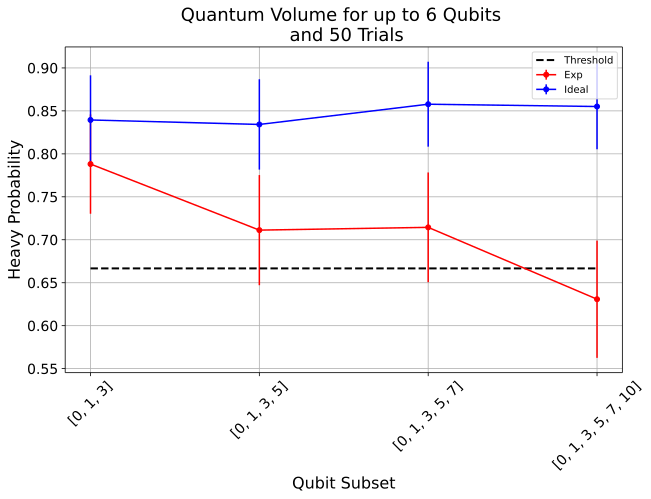

In [13]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# plot_rb_dataを呼び出して重要なポイントをプロットします
qv_fitter.plot_qv_data(ax=ax, show_plt=False)

# タイトルとラベルを追加
ax.set_title('Quantum Volume for up to %d Qubits \n and %d Trials'%(len(qubit_lists[-1]), ntrials), fontsize=18)

plt.show()

### ステップ 7: 量子ボリュームを計算する

量子ボリュームは、モデル回路の幅と深さを同等な重要度で扱い、量子コンピューターが平均して正常に実装できる最大の正方形(つまり、$m = d$)のモデル回路を測定します。

*量子ボリューム* $V_Q$は次のように定義されます

$$\log_2 V_Q = \arg\max_{m} \min (m, d(m))$$

それぞれの深さの統計をリストします。深さごとに、その深さに成功したかどうか、およびその信頼できる区間(confidence interval)をリストします。その深さが成功するためには、信頼できる区間が97.5％を超える必要があります。

In [14]:
qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
QV = 1
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx]>2/3:
        if qv_success_list[qidx][0]:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (successful). Quantum volume %d"%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1],qv_fitter.quantum_volume()[qidx]))
            QV = qv_fitter.quantum_volume()[qidx]
        else:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (unsuccessful)."%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1]))
    else:
        print("Width/depth %d less than 2/3 (unsuccessful)."%len(qubit_list))

Width/depth 3 greater than 2/3 (0.788105) with confidence 0.982193 (successful). Quantum volume 8
Width/depth 4 greater than 2/3 (0.711211) with confidence 0.756474 (unsuccessful).
Width/depth 5 greater than 2/3 (0.714434) with confidence 0.772706 (unsuccessful).
Width/depth 6 less than 2/3 (unsuccessful).


In [15]:
print ("The Quantum Volume is:", QV) 

The Quantum Volume is: 8


### 参考文献

[1] Andrew W. Cross, Lev S. Bishop, Sarah Sheldon, Paul D. Nation, and Jay M. Gambetta, *Validating quantum computers using randomized model circuits*, Phys. Rev. A **100**, 032328 (2019). https://arxiv.org/pdf/1811.12926

In [16]:
import qiskit.tools.jupyter
%qiskit_version_table

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}